In [2]:
import re
import collections
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt

In [3]:
# Import partially cleaned data
data = pd.read_csv("cleaned_airbnb_data.csv")

https://www.hoteldive.com/news/middle-income-travelers-spending-less/724070/

https://nypost.com/2024/04/16/business/budget-hotel-vacancies-top-50-as-inflation-weary-americans-cut-back-on-travel/?utm_source=chatgpt.com

National Economy hotel is $70 one night; middle-income travelers tend to spend $140 per night on average.

Therefore, we set three levels: 0-$70 Economy; $71-$140 Middle-level; >$140 Luxury

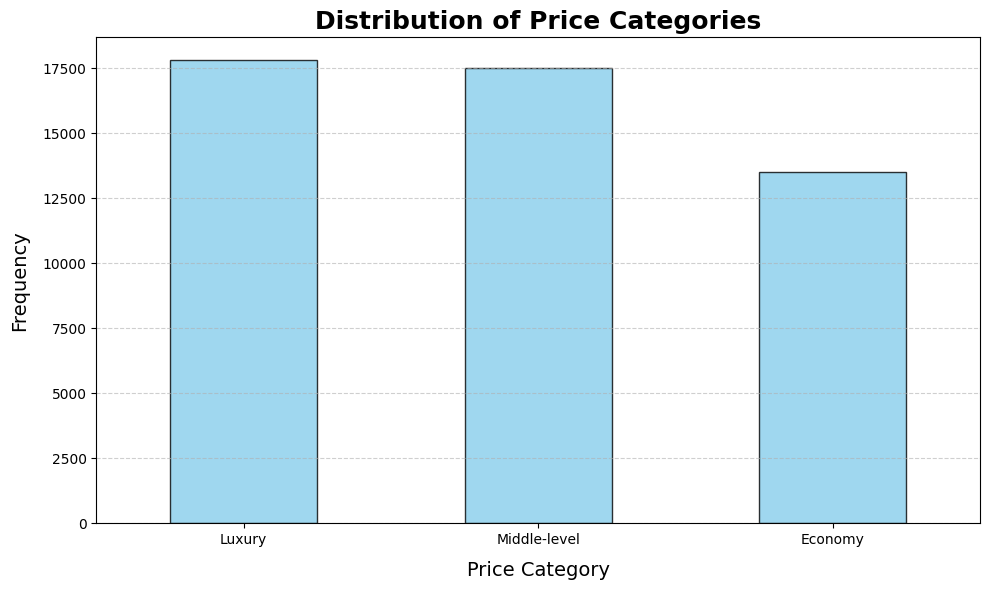

In [4]:
# Categories for price
data['price_category'] = pd.cut(
    data['price'],
    bins=[0, 70, 140, float('inf')],
    labels=['Economy', 'Middle-level', 'Luxury']
)

# Plot the histogram for the price categories to check the distribution
plt.figure(figsize=(10, 6))
data['price_category'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black', alpha=0.8)
plt.title('Distribution of Price Categories', fontsize=18, fontweight='bold')
plt.xlabel('Price Category', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Further clean

In [5]:
data = data.drop(columns=['id','name','host_id','host_name'])
data = data.dropna() 
# Drop the rows with missing values and columns that are not needed

Cluster

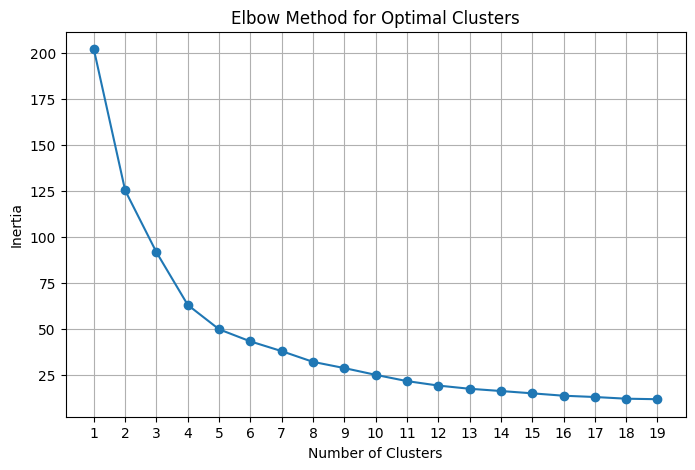

In [6]:
from sklearn.cluster import KMeans

# Extract longitude and latitude for clustering
coordinates = data[['latitude', 'longitude']]

# Determine the optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 20)  # Test 1 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coordinates)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid()
plt.show()

# Fit the KMeans model with the optimal number of clusters

In [7]:
# Optimal number of clusters
optimal_k = 5 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster'] = kmeans.fit_predict(coordinates)
data = data.drop(columns=['latitude','longitude'])

In [8]:
pip install folium

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [17]:
#Create cluster center points on the NYC map
import folium
print(kmeans.cluster_centers_)
# Create a base map centered around NYC
map_center = [40.7128, -74.0060]  # Approximate center of NYC
nyc_map = folium.Map(location=map_center, zoom_start=12)

# Add cluster center points with labels
for i, center in enumerate(kmeans.cluster_centers_):
    folium.Marker(
        location=center,
        popup=f'Cluster{i}',
        icon=folium.DivIcon(html=f"""
            <div style="font-size: 17px; color: blue;">
                Cluster {i}
            </div>
        """)
    ).add_to(nyc_map)   
#Create a map with the clusters
nyc_map


[[ 40.71087128 -73.8200211 ]
 [ 40.73910954 -73.98658603]
 [ 40.69718137 -73.93690921]
 [ 40.80482875 -73.9383723 ]
 [ 40.65503959 -73.98406418]]


In [10]:
from datetime import datetime

# Convert 'last_review' to datetime
data['last_review'] = pd.to_datetime(data['last_review'], errors='coerce')

# Extract other features
data['last_review_month'] = data['last_review'].dt.month
data=data.drop(columns=['last_review'])

In [11]:
# Move 'price' and 'price_category' columns to the end
columns_to_move = ['price', 'price_category']
data = data[[col for col in data.columns if col not in columns_to_move] + columns_to_move]
data

,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room,cluster,last_review_month,price,price_category
0,Kensington,1,9,0.21,6,365,1,0,0,0,1,0,4,10,149,Luxury
1,Midtown,1,45,0.38,2,355,0,1,0,0,0,0,1,5,225,Luxury
3,Clinton Hill,1,270,4.64,1,194,1,0,0,0,0,0,2,7,89,Middle-level
4,East Harlem,10,9,0.10,1,0,0,1,0,0,0,0,3,11,80,Middle-level
5,Murray Hill,3,74,0.59,1,129,0,1,0,0,0,0,1,6,200,Luxury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48745,Upper East Side,1,1,1.00,1,147,0,1,0,0,1,0,3,7,129,Middle-level
48753,Flushing,1,1,1.00,6,339,0,0,1,0,1,0,0,7,45,Economy
48762,Great Kills,1,1,1.00,1,87,0,0,0,1,1,0,4,7,235,Luxury
48768,Mott Haven,1,2,2.00,1,40,0,0,0,0,0,0,3,7,100,Middle-level


In [12]:
data.to_csv("airbnb_data_input.csv", index=False)

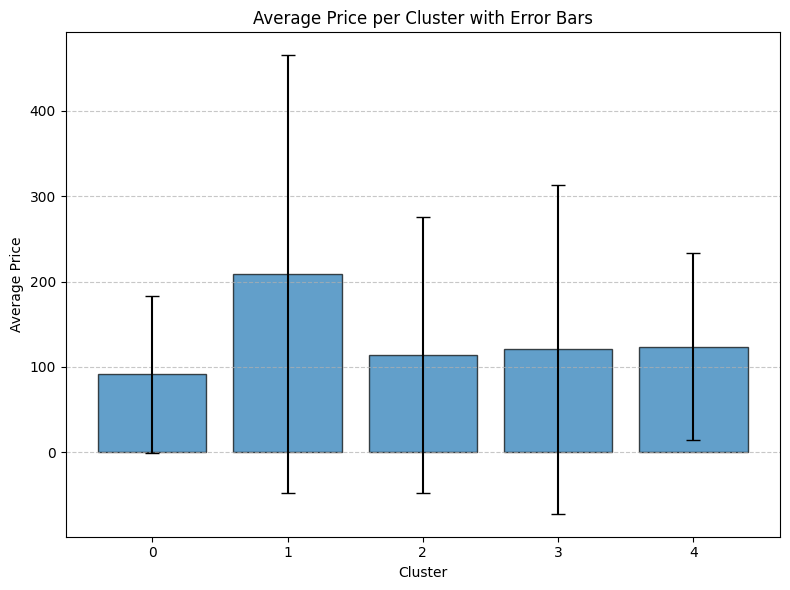

In [18]:
import numpy as np

# Calculate standard deviation for each cluster to use as error bars
std_price_per_cluster = data.groupby('cluster')['price'].std()

# Plot the average prices with error bars
plt.figure(figsize=(8, 6))
plt.bar(average_price_per_cluster.index, 
        average_price_per_cluster, 
        yerr=std_price_per_cluster, 
        capsize=5, 
        edgecolor='k', 
        alpha=0.7)
plt.title('Average Price per Cluster with Error Bars')
plt.xlabel('Cluster')
plt.ylabel('Average Price')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Numerical Descriptive Statistics:
              price  reviews_per_month  availability_365
count  38811.000000       38811.000000      38811.000000
mean     142.369199           1.373135        114.881631
std      197.006883           1.680276        129.535406
min       10.000000           0.010000          0.000000
25%       69.000000           0.190000          0.000000
50%      101.000000           0.720000         55.000000
75%      170.000000           2.020000        229.000000
max    10000.000000          58.500000        365.000000

Categorical Descriptive Statistics:
       room_type_Private room  room_type_Shared room
count            38811.000000           38811.000000
mean                 0.454691               0.021746
std                  0.497949               0.145856
min                  0.000000               0.000000
25%                  0.000000               0.000000
50%                  0.000000               0.000000
75%                  1.000000               0

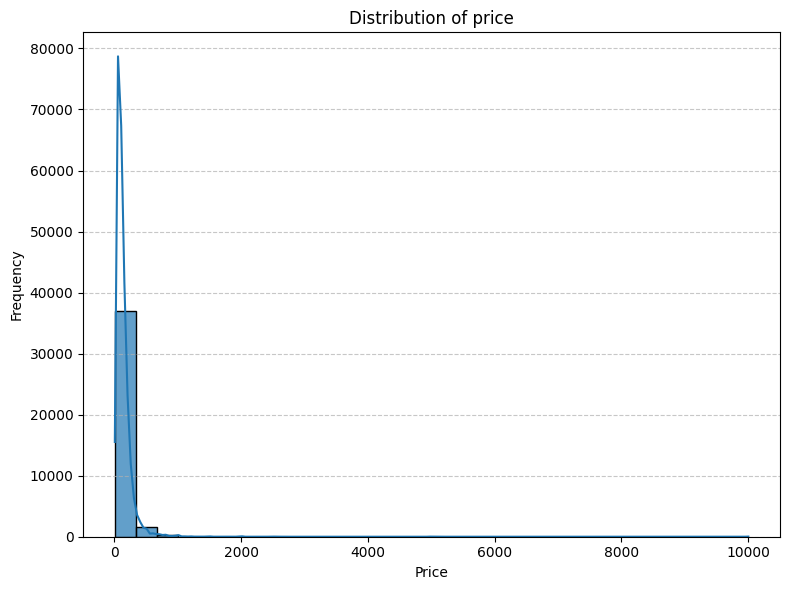

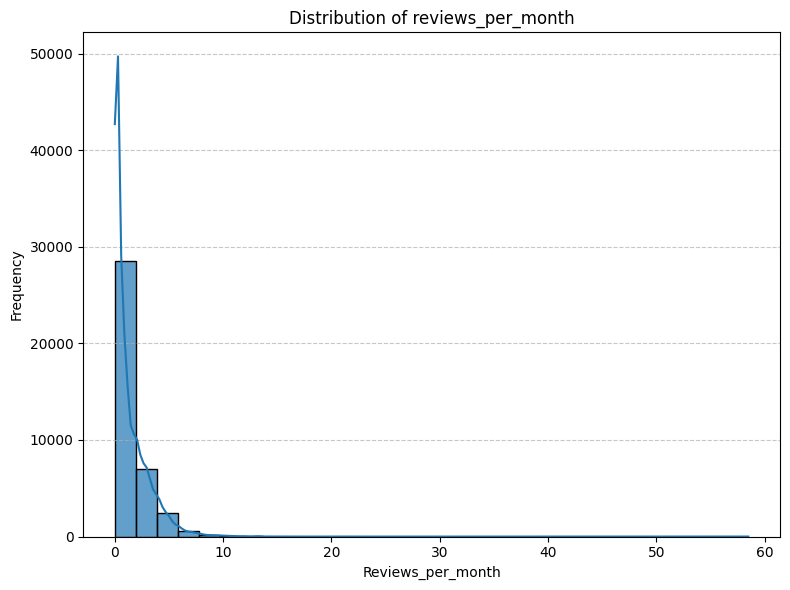

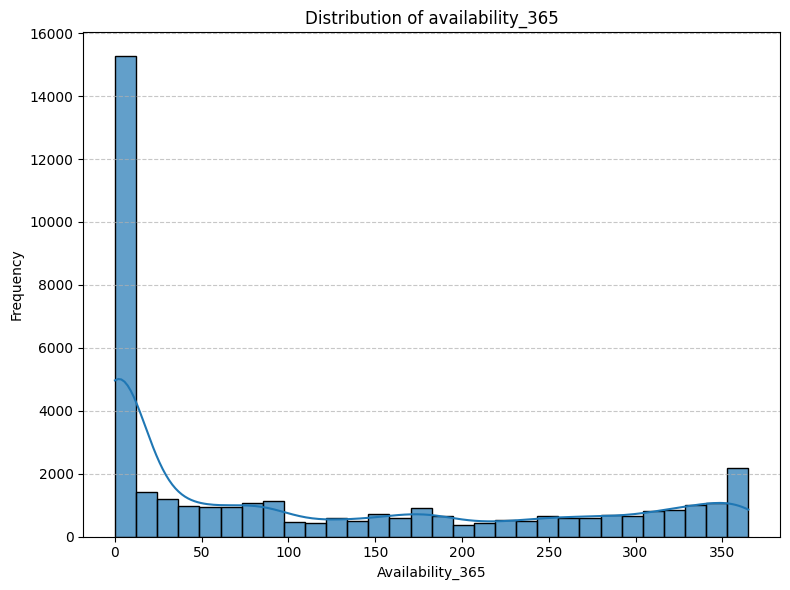

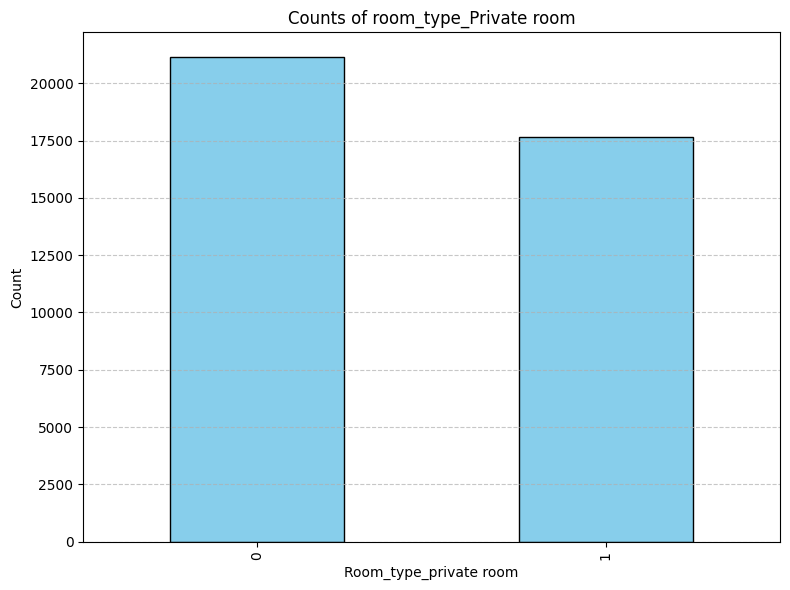

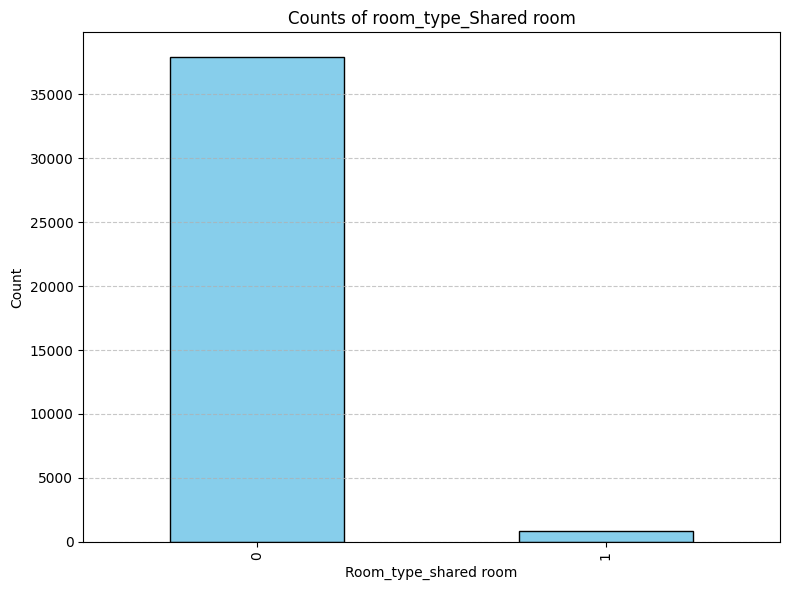

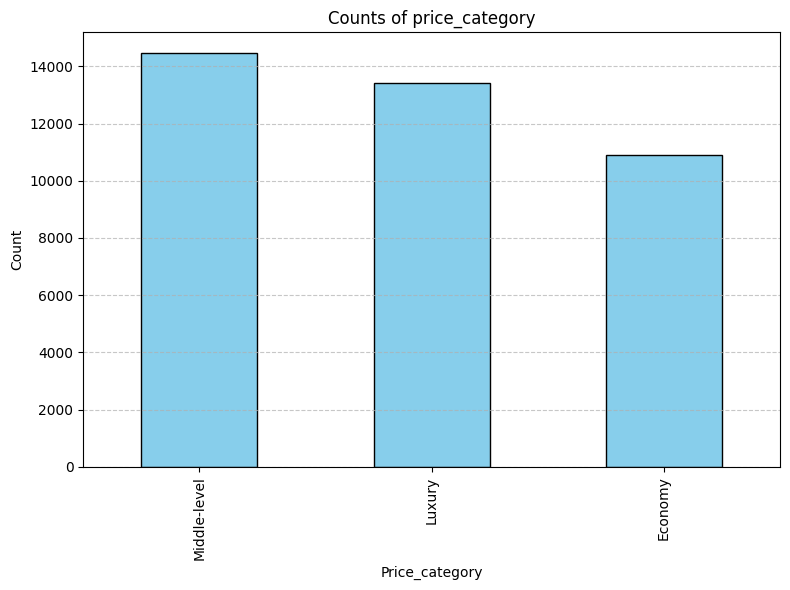

In [19]:
# Descriptive Analysis Code
# Select the relevant columns for analysis
columns_of_interest = ['price', 'room_type_Private room', 'room_type_Shared room', 
                       'reviews_per_month', 'availability_365', 'price_category']

# Numerical Descriptive Statistics
numerical_columns = ['price', 'reviews_per_month', 'availability_365']
numerical_summary = data[numerical_columns].describe()

print("Numerical Descriptive Statistics:")
print(numerical_summary)

# Categorical Descriptive Statistics
categorical_columns = ['room_type_Private room', 'room_type_Shared room', 'price_category']
categorical_summary = data[categorical_columns].describe()

print("\nCategorical Descriptive Statistics:")
print(categorical_summary)

# Distribution of Price Category
price_category_counts = data['price_category'].value_counts()
print("\nPrice Category Distribution:")
print(price_category_counts)

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram for numerical variables
for column in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], kde=True, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot bar chart for categorical variables
for column in categorical_columns:
    plt.figure(figsize=(8, 6))
    data[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='k')
    plt.title(f'Counts of {column}')
    plt.xlabel(column.capitalize())
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [25]:
import pandas as pd

# Define a function to remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile
    Q3 = df[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from numerical columns
numerical_columns = ['price', 'reviews_per_month', 'availability_365']
filtered_data = data.copy()
for column in numerical_columns:
    filtered_data = remove_outliers(filtered_data, column)

# Summary for Numerical Variables (after removing outliers)
numerical_summary_filtered = filtered_data[numerical_columns].describe()
print("Numerical Descriptive Statistics (After Removing Outliers):")
print(numerical_summary_filtered)

# Summary for Categorical Variables
categorical_columns = ['room_type_Private room', 'room_type_Shared room', 'price_category']
categorical_summary_filtered = filtered_data[categorical_columns].describe()
print("\nCategorical Descriptive Statistics:")
print(categorical_summary_filtered)

# Distribution of Price Category (After Filtering Outliers)
price_category_counts_filtered = filtered_data['price_category'].value_counts()
print("\nPrice Category Distribution (After Removing Outliers):")
print(price_category_counts_filtered)


Numerical Descriptive Statistics (After Removing Outliers):
              price  reviews_per_month  availability_365
count  35002.000000       35002.000000      35002.000000
mean     117.911605           1.127530        110.519170
std       65.121461           1.196402        129.204072
min       10.000000           0.010000          0.000000
25%       65.000000           0.180000          0.000000
50%      100.000000           0.630000         44.000000
75%      150.000000           1.807500        219.000000
max      321.000000           4.760000        365.000000

Categorical Descriptive Statistics:
       room_type_Private room  room_type_Shared room
count            35002.000000           35002.000000
mean                 0.471516               0.022856
std                  0.499195               0.149446
min                  0.000000               0.000000
25%                  0.000000               0.000000
50%                  0.000000               0.000000
75%                